In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import date

In [2]:
data = pd.read_csv('ETF_prices.csv')

for i in range(0, len(data)) :
    
    if not data.isnull().any(axis=1)[i] :
        
        break
    
data = data.iloc[i:,:]        

In [3]:
data.rename(index = dict(zip(np.array(data.index), data['Date'])) , inplace = True)
data.drop(['Date'], axis = 1, inplace = True)
data.index = pd.to_datetime(data.index)
data = data.fillna(method='ffill')
data.head()

,VEA,VEU,VB,IVV,QQQ,VGK,VIG,VWO,FXI,EWT,...,SLV,MUB,TLT,LQD,TIP,EMB,AGG,HYG,USO,VNQ
2007-12-19,34.5291,43.0941,57.8579,117.5223,45.2192,48.2898,44.5446,38.9805,44.7531,16.4400,...,13.985,74.4692,66.6759,68.2875,80.8342,60.4244,73.6989,49.4935,72.15,38.9009
2007-12-20,34.6447,43.2662,58.6721,118.3510,46.0885,48.5536,44.5852,39.1125,45.3332,16.2287,...,14.090,74.0088,66.5329,67.9567,80.7425,60.4483,73.6334,49.3869,72.10,38.7414
2007-12-21,35.2157,43.9919,59.5130,119.9118,46.9969,49.2354,45.2015,40.1497,46.7349,16.5179,...,14.215,73.9212,65.5603,67.8854,80.2538,60.3827,73.3132,49.5420,73.80,39.5015
2007-12-24,35.4144,44.4632,60.2080,120.8129,47.3504,49.4902,45.6258,40.8924,47.3011,17.1966,...,14.463,73.7604,65.2527,67.5416,80.0095,60.4901,73.3350,49.3675,73.95,40.7811
2007-12-26,35.6137,44.5613,60.3024,121.2233,47.5861,49.6229,45.5297,41.1920,47.0586,17.1497,...,14.597,73.6727,64.6806,67.5610,79.6582,60.5379,73.1094,49.1494,75.91,40.1033


In [4]:
import datetime 

def delta_t(x):
    
    y = x.notnull()
    
    for i in range(0, len(x)) :
        
        if y[i] :
            
            break
    
    return (x.index[-1] - x.index[i]).days

In [5]:
def first_adj(x):
    
    y = x.notnull()
    
    for i in range(0, len(x)) :
        
        if y[i] :
            
            break
    
    return x[i]

In [6]:
areturn = np.array(((data.iloc[-1,:] / data.apply(first_adj)) ** (1/(len(data) - 1)) - 1) * 252)
arisk = np.array(np.sqrt(data.pct_change().cov() * 252)).diagonal()
rf = 0.01
df = pd.DataFrame({'ETF' : data.columns, 'Annual volatility': arisk, 'Annual return':areturn,'Sharpe ratio' : (areturn - rf)/arisk})
df.sort_values(by=['Sharpe ratio'], ascending = False, inplace = True)
df.reset_index(drop = True, inplace = True)
df

C:\Users\a0972\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


,ETF,Annual volatility,Annual return,Sharpe ratio
0,QQQ,0.210856,0.126882,0.554320
1,MUB,0.053687,0.036265,0.489226
2,AGG,0.050830,0.034851,0.488911
3,LQD,0.085137,0.049212,0.460578
4,EMB,0.107978,0.054142,0.408801
5,VIG,0.174978,0.078441,0.391142
6,IVV,0.197885,0.080180,0.354650
7,VB,0.240699,0.094137,0.349553
8,HYG,0.122578,0.051523,0.338746
9,TIP,0.064293,0.031748,0.338265


## Without rebalance

In [7]:
combination = np.array(df['ETF'])[0:15]

W = []

P = []

V_R_S = []

k = len(combination)

kt = k

EF = []

ETF = [list(combination)]

iteration = 100000

j = 1

ptm = time.time()

while (k > kt) or (j == 1) :
    
    k = kt
    
    dat = data[combination]
  
    if k < 10 :

        iteration = 50000
        
    ps = np.zeros((iteration, k))
    
    weights = np.zeros((iteration, k))

    volatility_return_sharpe = np.zeros((iteration, 3))

    S0 = dat.apply(first_adj)

    T = len(dat)
    
    ####################### Monte Carlo approach ########################
    
    for i in range(0, iteration):

        p = np.random.random(k)
        p = p / np.sum(p)
        weight = np.array(p * dat.iloc[0, :] / np.dot(p, dat.iloc[0, :]))
        ps[i] = p
        weights[i] = weight

        ## Annual portfolio return volatility
        
        portfolio_volatility = pd.DataFrame(np.dot(dat, p)).pct_change().dropna().std() * np.sqrt(252)
        
        ##  Annual Portfolio average return 
        
        portfolio_average_return = ((np.dot(p, np.array(dat.iloc[-1,:])) / np.dot(p, np.array(S0))) ** (1/(T-1)) - 1 ) * 252
        
        ## Sharpe ratio

        rf = 0.01

        sharpe_ratio = (portfolio_average_return - rf) / portfolio_volatility

        volatility_return_sharpe[i] = np.array([portfolio_volatility, portfolio_average_return, sharpe_ratio])
     
    
    ########################## Best portfolio ###########################
    
    index = np.argmax(volatility_return_sharpe, axis = 0)[2]
    
    W.append(weights[index])
    
    P.append(ps[index])
    
    V_R_S.append(volatility_return_sharpe[index])
    
    
    ###################### Find Efficient frontier #######################
    
    pp = volatility_return_sharpe[:,0:2]
    
    ef = []

    for i in range(0, len(pp)) :

        one = two = three = four = 0

        ppp = pp - pp[i]

        # first

        if np.logical_and((ppp[:,1] > 0), (ppp[:,0] > 0)).sum() == 0  :

            one = 1

        # second    

        if np.logical_and((ppp[:,1] > 0), (ppp[:,0] < 0)).sum() == 0  :

            two = 1

        # third

        if np.logical_and((ppp[:,1] < 0), (ppp[:,0] < 0)).sum() == 0  :

            three = 1

        # fourth 

        if np.logical_and((ppp[:,1] < 0), (ppp[:,0] > 0)).sum() == 0  :

            four = 1

        if two > 0  :

            # if one == 0 and four == 0 :

            ef.append(i)

    EF.append(pp[ef])
      
    combination = combination[weights[index] > 0.03] 
    
    kt = len(combination)
    
    if k > kt :
    
        ETF.append(list(combination))
    
    print('%d simulation has done !'%(j))
    
    j += 1
    
print('Running time : %.2f seconds'%(round(time.time() - ptm, 2)))

1 simulation has done !
2 simulation has done !
3 simulation has done !
4 simulation has done !
Running time : 992.13 seconds


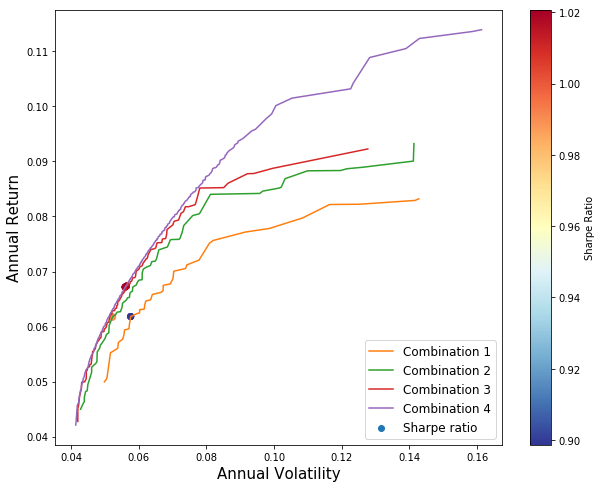

In [8]:
x=[x[:,0] for x in EF]
y=[x[:,1] for x in EF]

colours=['C1','C2','C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
cm = plt.cm.get_cmap('RdYlBu_r')

plt.figure(figsize=(10,8))

for i in range(len(x)):
    
    EFL = pd.DataFrame({'Volatility' : x[i], 'Returns': y[i]})
    EFL.sort_values(by=['Returns'], inplace = True)
    plt.plot(EFL['Volatility'], EFL['Returns'], colours[i], label = 'Combination ' + str(i+1))
    plt.scatter([x[0] for x in V_R_S], [x[1] for x in V_R_S], c = [x[2] for x in V_R_S], cmap=cm)
    
plt.scatter([x[0] for x in V_R_S], [x[1] for x in V_R_S], c = [x[2] for x in V_R_S], cmap=cm, label = 'Sharpe ratio')
plt.colorbar(label='Sharpe Ratio').ax.tick_params(labelsize = 10)
plt.rc('font', size=15)
plt.xlabel("Annual Volatility", fontsize = 15)
plt.ylabel("Annual Return", fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc='lower right', fontsize = 12)
plt.show()

In [9]:
V_R_S

[array([0.05766461, 0.06182037, 0.89865108]),
 array([0.05230997, 0.06175226, 0.98933831]),
 array([0.05641697, 0.0673609 , 1.01673122]),
 array([0.05601838, 0.067178  , 1.02070065])]

In [ ]:
## [Annual Volatility, Annual Return , Sharpe ratio] =  [0.05601838, 0.067178  , 1.02070065]

In [10]:
BW = 3

In [11]:
np.round(W[BW] * 100, 1)

array([21.1, 32.7, 24.1,  7.7, 14.4])

In [12]:
ETF[BW]

['QQQ', 'MUB', 'AGG', 'EMB', 'TLT']

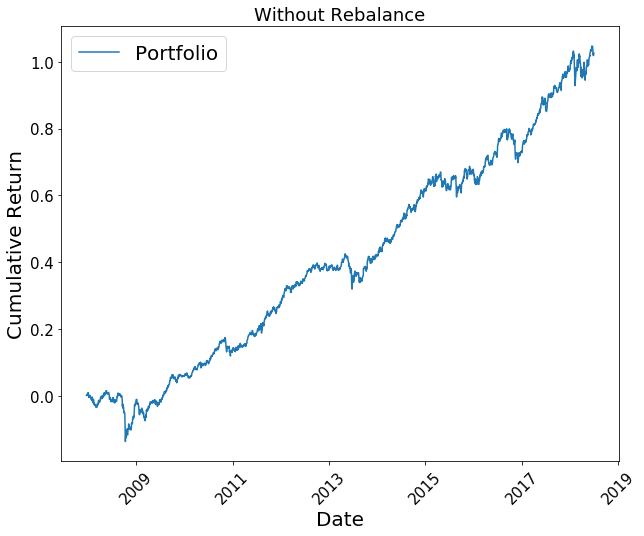

In [13]:
portfolio_df = pd.DataFrame({'Portfolio' : np.dot(np.array(data[ETF[BW]]), P[BW])})
portfolio_df.index = data.index
CumulativeReturns = ((1+portfolio_df.pct_change()[['Portfolio']]).cumprod()-1).dropna()
plt.figure(figsize=(10,8))
plt.plot(np.array(CumulativeReturns.index), CumulativeReturns, label = 'Portfolio')
plt.title('Without Rebalance')
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Cumulative Return", fontsize = 20)
plt.xticks(rotation='45', fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='upper left', fontsize = 20)
plt.savefig('Without rebalance.png')
plt.show()

## Rebalance

In [14]:
p = P[BW]
weight = W[BW]
dat = data[ETF[BW]]

port = []

rebalance = list(np.array(range(0, len(data), 252))-1)
rebalance[0] = 0

for r in range(0, (len(rebalance) - 1)) :

    if r == 0 :

        port = port + list((dat.iloc[rebalance[r]:(rebalance[r+1] + 1), :] * p).sum(axis = 1))

    else :

        port = port + list((dat.iloc[(rebalance[r] + 1):(rebalance[r+1] + 1), :] * p).sum(axis = 1))

    newp = np.array(np.dot(dat.iloc[rebalance[r+1], :], p) * weight / dat.iloc[rebalance[r+1], :])

    p = newp


if (rebalance[-1] + 1) < len(dat) :

    port = port + list((dat.iloc[(rebalance[-1] + 1):len(dat), :] * p).sum(axis = 1))

## Annual portfolio return volatility

# portfolio_volatility = np.sqrt(np.dot(weight.T, np.dot(return_rate, weight)) * 252)

portfolio_volatility = (pd.DataFrame(port).pct_change().dropna().std() * np.sqrt(252))[0]

##  Annual Portfolio average return

portfolio_average_return = ((port[-1]/port[0]) ** (1/(len(port) - 1)) -1) * 252  


## Sharpe ratio

rf = 0.01

sharpe_ratio = (portfolio_average_return - rf) / portfolio_volatility

volatility_return_sharpe = np.array([portfolio_volatility, portfolio_average_return, sharpe_ratio])

In [15]:
np.round(V_R_S[BW], 3)

array([0.056, 0.067, 1.021])

In [16]:
np.round(volatility_return_sharpe, 3)

array([0.053, 0.067, 1.065])

In [17]:
round(df.loc[df['ETF'].isin(ETF[BW])], 3)

,ETF,Annual volatility,Annual return,Sharpe ratio
0,QQQ,0.211,0.127,0.554
1,MUB,0.054,0.036,0.489
2,AGG,0.051,0.035,0.489
4,EMB,0.108,0.054,0.409
10,TLT,0.149,0.057,0.316


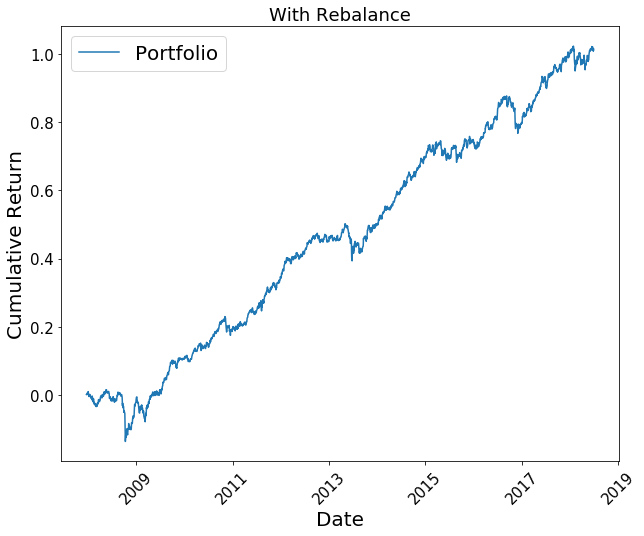

In [18]:
portfolio_df = pd.DataFrame({'Portfolio' : port})
portfolio_df.index = data.index
CumulativeReturns = ((1+portfolio_df.pct_change()[['Portfolio']]).cumprod()-1).dropna()
plt.figure(figsize=(10,8))
plt.plot(np.array(CumulativeReturns.index), CumulativeReturns, label = 'Portfolio')
plt.title('With Rebalance')
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Cumulative Return", fontsize = 20)
plt.xticks(rotation='45', fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc='upper left', fontsize = 20)
plt.savefig('With rebalance.png')
plt.show()

In [ ]:
'''
#combination = np.array(df['ETF'])[0:15]

combination = np.array(['QQQ', 'MUB', 'AGG', 'TLT', 'TIP'])

W = []

P = []

V_R_S = []

k = len(combination)

kt = k

EF = []

ETF = [list(combination)]

Port = []

iteration = 100000

j = 1

ptm = time.time()

while (k > kt) or (j == 1) :
    
    k = kt
    
    dat = data[combination]

    return_rate = dat.pct_change().dropna().cov()
    
    if k < 10 :
    
        iteration = 50000
        
    ps = np.zeros((iteration, k))
    
    weights = np.zeros((iteration, k))

    volatility_return_sharpe = np.zeros((iteration, 3))

    T = dat.apply(delta_t)
    
    
    rebalance = list(np.array(range(0, len(data), 252))-1)
    rebalance[0] = 0
    
    ports = []
    
    ####################### Monte Carlo approach ########################

    for i in range(0, iteration):

        p = np.random.random(k)
        p = p / np.sum(p)
        weight = np.array(p * dat.iloc[0, :] / np.dot(p, dat.iloc[0, :]))
        ps[i] = p
        weights[i] = weight

        port = []
        
        for r in range(0, (len(rebalance) - 1)) :

            if r == 0 :

                port = port + list((dat.iloc[rebalance[r]:(rebalance[r+1] + 1), :] * p).sum(axis = 1))

            else :

                port = port + list((dat.iloc[(rebalance[r] + 1):(rebalance[r+1] + 1), :] * p).sum(axis = 1))

            newp = np.array(np.dot(dat.iloc[rebalance[r+1], :], p) * weight / dat.iloc[rebalance[r+1], :])

            p = newp


        if (rebalance[-1] + 1) < len(dat) :


            port = port + list((dat.iloc[(rebalance[-1] + 1):len(dat), :] * p).sum(axis = 1))
            
        ports.append(port)
        
        ## Annual portfolio return volatility

        # portfolio_volatility = np.sqrt(np.dot(weight.T, np.dot(return_rate, weight)) * 252)
        
        portfolio_volatility = pd.DataFrame(port).pct_change().dropna().std() * np.sqrt(252)
        
        ##  Annual Portfolio average return

        portfolio_average_return = ((port[-1]/port[0]) ** (1/T[0]) -1) * 252  
        

        ## Sharpe ratio

        rf = 0.01

        sharpe_ratio = (portfolio_average_return - rf) / portfolio_volatility

        volatility_return_sharpe[i] = np.array([portfolio_volatility, portfolio_average_return, sharpe_ratio])
     
    
    ########################## Best portfolio ###########################
    
    index = np.argmax(volatility_return_sharpe, axis = 0)[2]
    
    # index = np.argmin(volatility_return_sharpe, axis = 0)[0]
    
    W.append(weights[index])
    
    P.append(ps[index])
    
    V_R_S.append(volatility_return_sharpe[index])
    
    Port.append(ports[index])
    
    ###################### Find Efficient frontier #######################
    
    pp = volatility_return_sharpe[:,0:2]
    
    ef = []

    for i in range(0, len(pp)) :

        one = two = three = four = 0

        ppp = pp - pp[i]

        # first

        if np.logical_and((ppp[:,1] > 0), (ppp[:,0] > 0)).sum() == 0  :

            one = 1

        # second    

        if np.logical_and((ppp[:,1] > 0), (ppp[:,0] < 0)).sum() == 0  :

            two = 1

        # third

        if np.logical_and((ppp[:,1] < 0), (ppp[:,0] < 0)).sum() == 0  :

            three = 1

        # fourth 

        if np.logical_and((ppp[:,1] < 0), (ppp[:,0] > 0)).sum() == 0  :

            four = 1

        if two > 0  :

            # if one == 0 and four == 0 :

            ef.append(i)

    EF.append(pp[ef])
    
    combination = combination[weights[index] > 0.03] 
    
    kt = len(combination)
    
    if k > kt :
    
        ETF.append(list(combination))
    
    print('%d simulation has done !'%(j))
    
    j += 1
    
print('Running time : %.2f seconds'%(round(time.time() - ptm, 2)))

'''

In [ ]:
'''
x=[x[:,0] for x in EF]
y=[x[:,1] for x in EF]

colours=['C1','C2','C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
cm = plt.cm.get_cmap('RdYlBu_r')

plt.figure(figsize=(10,8))

for i in range(len(x)):
    
    EFL = pd.DataFrame({'Volatility' : x[i], 'Returns': y[i]})
    EFL.sort_values(by=['Returns'], inplace = True)
    plt.plot(EFL['Volatility'], EFL['Returns'], colours[i], label = 'Combination ' + str(i+1))
    plt.scatter([x[0] for x in V_R_S], [x[1] for x in V_R_S], c = [x[2] for x in V_R_S], cmap=cm)
    
plt.scatter([x[0] for x in V_R_S], [x[1] for x in V_R_S], c = [x[2] for x in V_R_S], cmap=cm, label = 'Sharpe ratio')
plt.colorbar(label='Sharpe Ratio').ax.tick_params(labelsize = 10)
plt.rc('font', size=15)
plt.xlabel("Volatility", fontsize = 15)
plt.ylabel("Returns", fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc='lower right', fontsize = 12)
plt.show()
'''